In [712]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

<AxesSubplot:xlabel='time'>

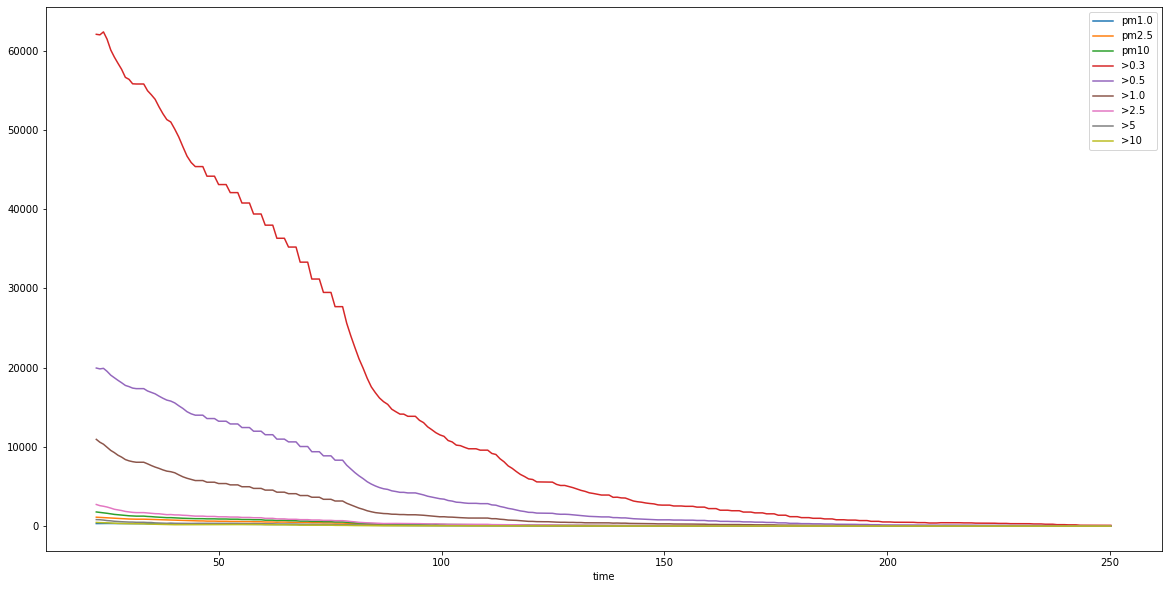

In [713]:
#df = pd.read_csv('20220623_4_ArcticP14_4_ikea_100_pwr.csv')
df = pd.read_csv('20220623_2_iPPC3000_2_ikea_100_pwr.csv')
#df = pd.read_csv('20220623_2_iPPC3000_2_ikea_66_pwr.csv')
#df = pd.read_csv('20220623_Levoit400s_4_spd.csv')
#df = pd.read_csv('20220623_ACH_vd.csv')
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

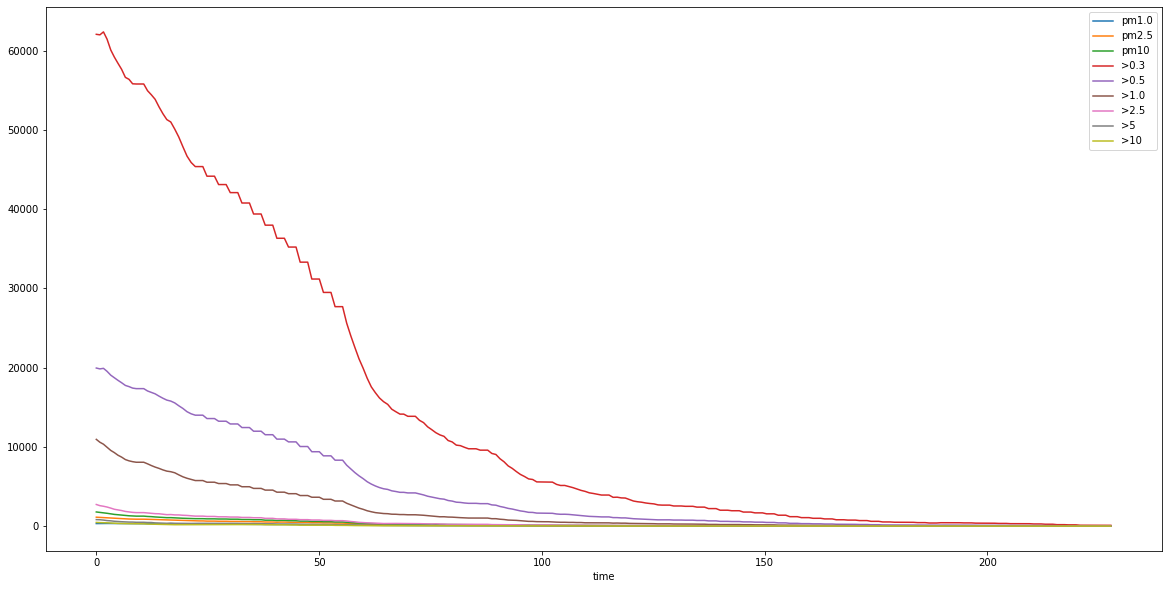

In [714]:
# cut off all records before >0.3um was below 65535, sensor values may be incorrect before then since it's at max 16-bit unsigned int
drop_start_idx = df[df['>0.3'] < 65535].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx)
# adjust times according to new t0 after tail was run
df.time = df.time - df.time.iloc[0]
df.index = df.index - df.index[0]
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

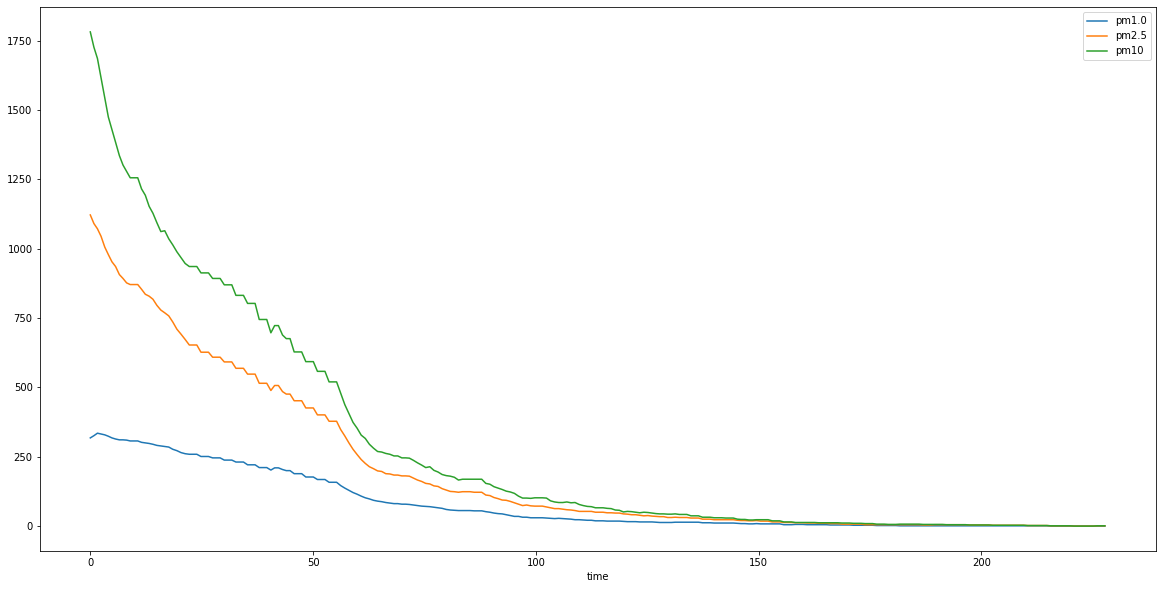

In [715]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

# Logarithmic Fit

First thing to do is a curve fit to the logarithmic decay function from the UC Davis paper.

ACH: 84.25412014490513
stddev: 0.6961524271511207


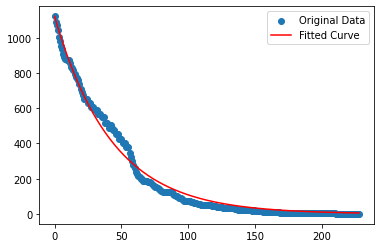

In [716]:
df_pm25 = df[['time','pm2.5']].copy()

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
C_bgd = 0
C_pt0 = df_pm25['pm2.5'][df.index[0]]

## logarithmic function
def func(t, ACH):
    # divide by 3600 to convert seconds to hours
    return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

popt, pcov = curve_fit(func, df_pm25.time, df_pm25['pm2.5'])
print('ACH: {}'.format(popt[0]))
print('stddev: {}'.format(np.sqrt(np.diag(pcov))[0]))
plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

Fit looks... ok? Let's look at a log plot of the data, ideally it's a straight line that fits very well.

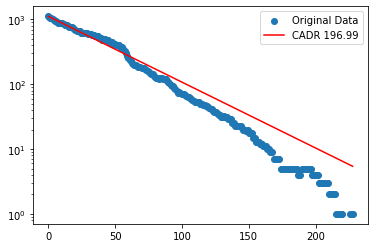

In [717]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd = 3.658926048639792
ACH_f = popt[0] - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()

On the log plot it can be seen that the fit isn't very good. It misses the lower end of the data. The problem with the logarthimic fit using the least squares method (this is default mode of scipy's curve_fit) is the large values at the beginning of the dataset dominate and that weird hump at t=50 that seems like an error of some sort throws off the fit. So least squares fits the top end really well but ignores the bottom end. Not good!

What if instead of doing the fit on the log dataset, it's a linear fit on values that have already been log-transformed? That way least squares wouldn't overweight the top end values.

# Linear Fit

ACH: 103.67867400898827
stddev: 0.4424914543589492


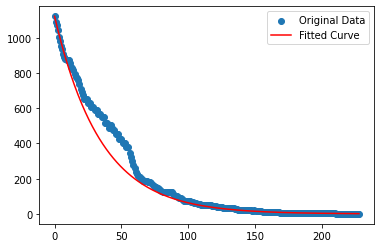

In [718]:
df_pm25 = df[['time','pm2.5']].copy()

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
C_bgd = 0
C_pt0 = df_pm25['pm2.5'][df.index[0]]

## logarithmic function
def func(t, ACH):
    # divide by 3600 to convert seconds to hours
    return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

# the natural log of func. Since C_bgd is zero for us, it is ignored here.
def linear_func(t, ACH):
    return np.log(C_pt0) - ACH * t / 3600

pm25 = df_pm25['pm2.5'].copy()
pm25 = np.where(pm25 == 0, 1, pm25) # change the zeroes to 1 so the log func doesn't break
popt, pcov = curve_fit(linear_func, df_pm25.time, np.log(pm25))
print('ACH: {}'.format(popt[0]))
print('stddev: {}'.format(np.sqrt(np.diag(pcov))[0]))
plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

Pretty good! The weird hump at t=50 is ignored. How does it look plotted on log scale?

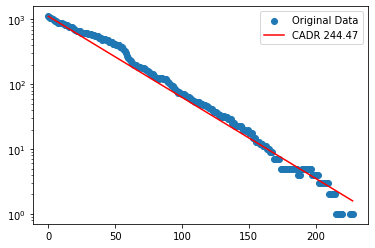

In [719]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd = 3.658926048639792
ACH_f = popt[0] - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()

It looks ok but possibly with too large of a slope. This dataset doesn't show it as well as others but just as least squares overweights the large values in a log fit, it overweights the small values in a linear fit. This can be improved by throwing out values below a certain level. Looking at data from several trials, a good value to pick where things start to get noisy and diverge from the line is pm2.5 < 25. So, what happens when data below that level is thrown out?

ACH: 95.46503914594582
stddev: 0.5332549718528914


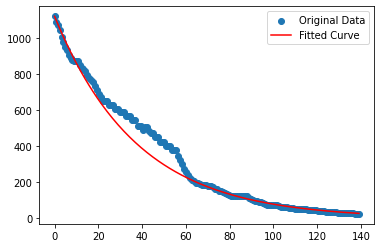

In [720]:
df_pm25 = df[['time','pm2.5']].copy()

# cut all values after pm2.5 gets to about 25, they have an outsized impact on fit after converting to log
lt25_iloc = df_pm25[df_pm25['pm2.5'] < 25].index[0]
df_pm25 = df_pm25[:lt25_iloc]

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
C_bgd = 0
C_pt0 = df_pm25['pm2.5'][df.index[0]]

## logarithmic function
def func(t, ACH):
    # divide by 3600 to convert seconds to hours
    return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

def linear_func(t, ACH):
    return np.log(C_pt0) - ACH * t / 3600

popt, pcov = curve_fit(linear_func, df_pm25.time, np.log(df_pm25['pm2.5']))
print('ACH: {}'.format(popt[0]))
print('stddev: {}'.format(np.sqrt(np.diag(pcov))[0]))
plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

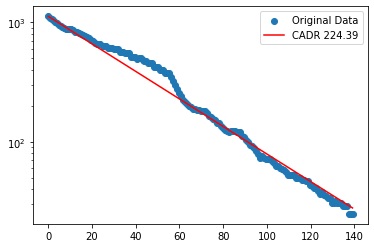

In [721]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd = 3.658926048639792
ACH_f = popt[0] - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()

This fit look good! The bump around t=50 seems to be skewing the CADR a little lower than it might actually be, but the fitting is solid.

Running on the levoit 400s dataset gives a CADR of 265.52, very close to mfg CADR spec of 260 CFM.